# Capstone Project 1 - In-Depth Analysis
## Name: Brock Nosbisch

#### Summary:
# Ignore the Markdown text as it needs to be changed.

# [FILL IN]



# Load Packages / Data / Notebooks

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy import stats
# from statsmodels.nonparametric.kernel_regression import KernelReg

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score, SCORERS

from sklearn.neighbors import KNeighborsClassifier

file_name = 'eda_out.csv'
df = pd.read_csv(file_name, header=0, na_values ='-1')
df.set_index('id', inplace=True)
# df.info()


In [6]:
# Import my data story notebook.
# import import_ipynb
# import Chapter_3_Capstone_1_EDA as ds

# sorted(SCORERS.keys())

In [7]:
def pearsonr_ci(x,y,alpha=0.05):

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    low_z, high_z = r_z-z*se, r_z+z*se
    low, high = np.tanh((low_z, high_z))
    return r, p, low, high

# Bootstrap Replicates	
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# Test SVM
# Pass X_train, y_train, X_test, y_test, Maximum Iterations you want, C values in a list 
def svm_test(X_train, y_train, X_test, y_test, maxiter=1000, crange=[0.01,0.1,1,10,100]):
    # X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=10)
    model = svm.LinearSVC(C=1, random_state=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #tune parameter C
    # crange = [0.01,0.1,1,10,100,1000]
    for num in crange:
        model = svm.LinearSVC(C=num, max_iter = maxiter)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print ('C=' + str(num) + ',score={}'.format(accuracy_score(y_test,y_pred)))
        print(confusion_matrix(y_test, y_pred))
        
def print_stats(y_test, y_pred):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print()
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print()
    print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
# df = ds.df


In [8]:

# Find monthly income median
df['monthly_income'][df['monthly_income'].isnull()] = 0
df.astype({'monthly_income':'int64'})
monthly_median = np.median(df['monthly_income'])
df.loc[df.monthly_income == 0, 'monthly_income'] = monthly_median # Set the 0's to median value.

# Need to do a little clean up on number_of_dependents
df['number_of_dependents'] = df['number_of_dependents'].fillna(0)

X = df.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name']) # ,'monthly_income']) # Drop columns not needed.
y = df['serious_delinquent']

# Split the Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50) 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Logistic Regression

### The Confusion Matrix is showing the below which looks good:
* Accuracy was 93.6% (56,107 out of 59,892)
* Precision was 94% (tp / (tp + fp))
* Recall was 99.4% (tp / (tp + fn))
* F1 Score is 96.6%

### But if I look at how well I did predicting the Defaults, the model predicted a total of 741 Defaults and 451 of those were actual Defaults.  The total actual count of Defaults was 3,946.  These results are not satisfactory.
* Predicted 451 defaults out of 3,946 total defaults (11%)
* Out of 741 predicted defaults, 451 were actual defaults (61%)
* F1 Score is 19%


In [9]:


logreg = LogisticRegression(solver='liblinear') # Create the classifier
logreg.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)

# print('Logistic Regression Classifier Accuracy: ' + str(accuracy_score(y_pred, y_test)))
# print()
# print('Confusion Matrix:')
# print(confusion_matrix(y_test, y_pred))
# print()
# print()
# print('Classification Report:')
# print(classification_report(y_test, y_pred))

# print(df)


Logistic Regression Classifier Accuracy: 0.9379716823615842

Confusion Matrix:
[[55560   386]
 [ 3329   617]]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.62      0.16      0.25      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.78      0.57      0.61     59892
weighted avg       0.92      0.94      0.92     59892



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### The Average 10-fold Cross Validation score is 93.8%.

In [10]:
# Cross Validation

logreg3 = LogisticRegression(solver='liblinear') # Create the classifier
cv_scores = cross_val_score(logreg3, X_test, y_test, cv=10)
print('CV Scores:')
print(cv_scores)
print()
cv_score_avg = np.mean(cv_scores)
print('Average k-fold CV Score: ' + str(cv_score_avg))
print()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CV Scores:
[0.9360601  0.93739566 0.93689482 0.93789649 0.94156928 0.9375626
 0.93937876 0.93904476 0.94071476 0.93553774]

Average k-fold CV Score: 0.9382054983645645



### It seems that using optimizing the parameters did not help since the matrix is exactly the same as above.

In [11]:
# GridSearchCV with LogReg

# Split the Training and Test Sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50) 

logreg = LogisticRegression(solver='liblinear') # Create the classifier

penalty = ['l1', 'l2'] # regularization penablty space
C = np.logspace(0, 4, 10) # regularization hyperparameter space

param_grid = dict(C=C, penalty=penalty)
# scoring = {'AUC': 'roc_auc', 'ROC AUC SCORE': 'roc_auc_score', 'Balanced Accuracy': 'balanced_accuracy_score'}

logreg_cv = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5, n_jobs=-1) # 5 fold
logreg_cv.fit(X_train, y_train) # Fit the classifier to the training data

# print('cv_results')
# print(logreg_cv.cv_results_)
# print()
# print('best estimator')
# print(logreg.best_estimator_)
# print()
# print('best score')
# print(logreg.best_score_)
# print()
# print('best params')
# print(logreg.best_params_)

y_pred = logreg_cv.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)

# print('Logistic Regression Classifier Accuracy: ' + str(accuracy_score(y_pred, y_test)))
# print()
# print('Confusion Matrix:')
# print(confusion_matrix(y_test, y_pred))
# print()
# print()
# print('Classification Report:')
# print(classification_report(y_test, y_pred))


Logistic Regression Classifier Accuracy: 0.9380050758031123

Confusion Matrix:
[[55506   440]
 [ 3273   673]]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.60      0.17      0.27      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.77      0.58      0.62     59892
weighted avg       0.92      0.94      0.92     59892



## Logistic Regression (Balanced)
### After passing the class_weight='balanced' parameter, the Confusion Matrix is showing the below which appears to be worse than above.
* Accuracy was 83.8% (50,238 / 59,892)
* Precision was 97%
* Recall was 85%
* F1 Score is 91%

### But since the weighting was balanced (n_samples / (n_classes * np.bincount(y))), the model predicted a total of 10,860 Defaults and 2,576 of those were actual Defaults.  The total actual count of Defaults was 3,946.
* Predicted 2,576 defaults out of 3,946 total defaults (65%)
* Out of 10,860 predicted defaults, 2,576 were actual defaults (24%)
* F1 Score is 35%

### So using the Balanced method gave us a much higher percentage (65%) of finding all the Defaults but 8,284 predicted defaults did not actually default (15% of all non-defaulters).  This may seem like the balanced model was worse but the model is being used to find the people who will default.  Since defaulters cost the company a lot more than the non-defaulters make in revenue then wrongly classifying a non-defaulter as a defaulter is an okay trade-off.


In [12]:

# Logistic Regression (balanced)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

logreg_bal = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier
logreg_bal.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg_bal.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)

# print('Logistic Regression Classifier Accuracy: ' + str(accuracy_score(y_pred, y_test)))
# print()
# print('Confusion Matrix:')
# print(confusion_matrix(y_test, y_pred))
# print()
# print()
# print('Classification Report:')
# print(classification_report(y_test, y_pred))


Logistic Regression Classifier Accuracy: 0.838743070860883

Confusion Matrix:
[[47657  8289]
 [ 1369  2577]]


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     55946
           1       0.24      0.65      0.35      3946

   micro avg       0.84      0.84      0.84     59892
   macro avg       0.60      0.75      0.63     59892
weighted avg       0.92      0.84      0.87     59892



### The Average 10-fold Cross Validation score is 83.2%.

In [13]:
# Cross Validation w/ Balance

logreg3 = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier
cv_scores = cross_val_score(logreg3, X_test, y_test, cv=10)
print('CV Scores:')
print(cv_scores)
print()
cv_score_avg = np.mean(cv_scores)
print('Average k-fold CV Score: ' + str(cv_score_avg))
print()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CV Scores:
[0.83422371 0.84173623 0.83689482 0.83689482 0.83889816 0.84774624
 0.84335337 0.83750835 0.84051436 0.83767535]

Average k-fold CV Score: 0.8395445426189051



## ROC Curve of Balanced Logistic Regression

ROC AUC Score: 0.8254011602202247



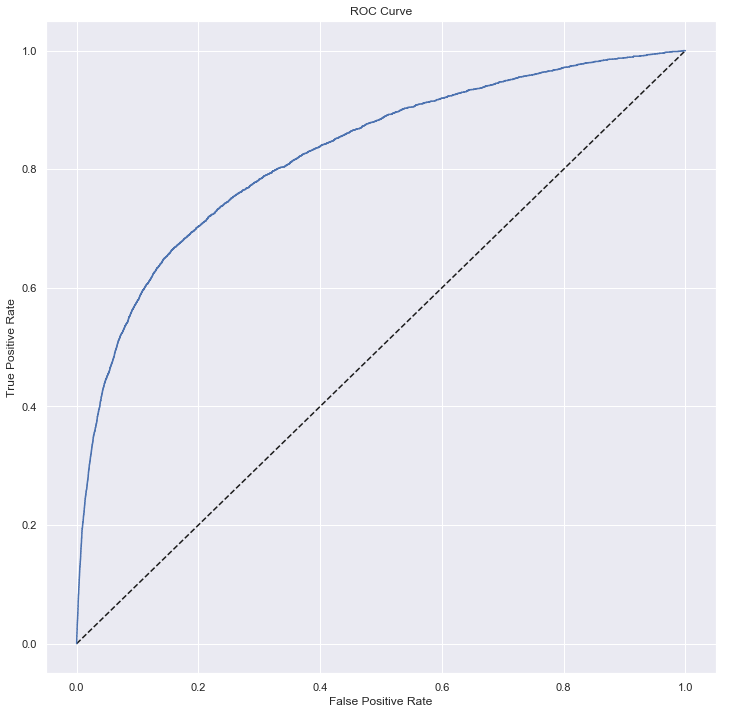

In [14]:
# ROC Curve
y_pred_prob = logreg_bal.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# k-NN

### Finding the Best Params / Score to use results in using k = 5 and results in a k-NN Score of 93.3%

In [15]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

param_grid = {'n_neighbors': np.arange(1,12)}

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1) # 5 Fold Cross Validation

knn_cv.fit(X_train, y_train)

print('k-NN Best Params: {}'.format(knn_cv.best_params_))
print('k-NN Best Score: {}'.format(knn_cv.best_score_))

knn_neighbors = knn_cv.best_params_


k-NN Best Params: {'n_neighbors': 10}
k-NN Best Score: 0.933925510363098


In [16]:
knn = KNeighborsClassifier(n_neighbors=knn_neighbors['n_neighbors'], weights='uniform')

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Prediction: {}'.format(y_pred))
print('k-NN Score: {}'.format(knn.score(X_test, y_test)))

Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.9340980431443264


### The Confusion Matrix for k-NN with k=10 has the below results which look really good!
* Accuracy was 93.4% (55,945 / 59,892)
* Precision was 93%
* Recall was 100%
* F1 Score is 97%

### But the model basically just said that all but 3 people would not default.  This does not help us since we want to identify those defaulters.  Next I will upsample the defaults.


In [40]:
print_stats(y_test, y_pred)

Confusion Matrix:
[[55464   482]
 [ 3343   603]]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.56      0.15      0.24      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.75      0.57      0.60     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.9361350430775396


### Upsampling the Defaults so that the occurence of Defaults vs. non-Defaults is 50/50.

In [18]:
# Split the Training and Test Sets for upsampling.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=.4, random_state=50) 

X_train_2['serious_delinquent'] = y_train_2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
# Resampling to Upsample our Defaults.

from sklearn.utils import resample

# Separating default and non-defaults
df_default = X_train_2[X_train_2['serious_delinquent'] == 1] 
df_no_default = X_train_2[X_train_2['serious_delinquent'] == 0]

print('Number of Defaults: {}'.format(np.ma.count(df_default['serious_delinquent'])))
print('Number of Non-Defaults: {}'.format(np.ma.count(df_no_default['serious_delinquent'])))

resample_count = np.ma.count(df_no_default['serious_delinquent']) - np.ma.count(df_default['serious_delinquent'])
print('Difference: {}'.format(resample_count)) # This is the amount of resamples I need to make
print()

df_default_samples = resample(df_default, replace=True, n_samples=resample_count, random_state=50) # Resampling
print('Number of New Defaults (resampled): {}'.format(np.ma.count(df_default_samples['serious_delinquent'])))
print()

df_resampled = pd.concat([df_default, df_default_samples, df_no_default]) # combine all data
print('Count of Records after Resampling: {}'.format(np.ma.count(df_resampled['serious_delinquent'])))



Number of Defaults: 5933
Number of Non-Defaults: 83905
Difference: 77972

Number of New Defaults (resampled): 77972

Count of Records after Resampling: 167810


### Resampling with k=10 (best param / score).  With this method we were able to correctly identify 3,839 out 3,946 Defaults (a whopping 97%!) and only wrongly predicted 8,640 out of 55,946 (15%) non-defaulters.  So far this is the best predictor we have.

In [20]:

# Resampled dependent/independent.
X_r = df_resampled.drop(columns = ['serious_delinquent']) # ,'age_bucket_name','monthly_income_name']) # Drop columns not needed.
y_r = df_resampled['serious_delinquent']


knn = KNeighborsClassifier(n_neighbors=knn_neighbors['n_neighbors'])

X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=.4, random_state=50)

knn.fit(X_r_train, y_r_train)

# y_r_pred = knn.predict(X_r_test)

# print('Prediction: {}'.format(y_r_pred))
# print('k-NN Score: {}'.format(knn.score(X_r_test, y_r_test)))
# Running the below doesn't really tell us much because the prediction was run on the balanced dataset.
# print('Confusion Matrix:')
# print(confusion_matrix(y_r_test, y_r_pred))
# print('Classification Report:')
# print(classification_report(y_r_test, y_r_pred))


##################################################

# Now running on the original dataset to see what our output is.
y_r_pred = knn.predict(X_test)  # Use the actual dataset to test

print('Prediction: {}'.format(y_r_pred))
print('k-NN Score: {}'.format(knn.score(X_test, y_test)))
print()

# Running the below doesn't really tell us much because the prediction was run on the balanced dataset.

print_stats(y_test, y_r_pred)


Prediction: [1 0 0 ... 1 0 0]
k-NN Score: 0.6944333132972684

Confusion Matrix:
[[39942 16004]
 [ 2297  1649]]


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.81     55946
           1       0.09      0.42      0.15      3946

   micro avg       0.69      0.69      0.69     59892
   macro avg       0.52      0.57      0.48     59892
weighted avg       0.89      0.69      0.77     59892



### ROC Curve results in an AUC Score of 97.5%

ROC AUC Score: 0.5970523509482906



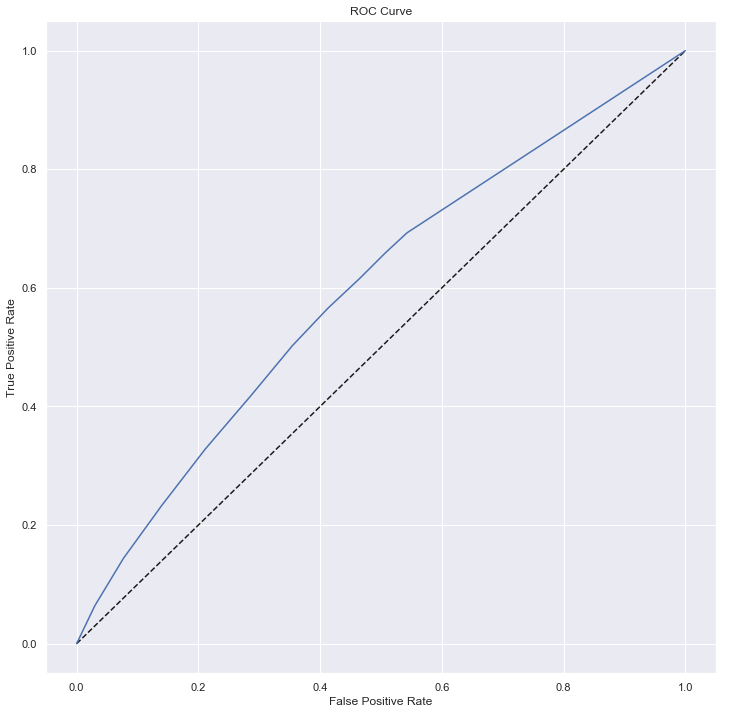

In [21]:
# ROC Curve
y_r_pred_prob = knn.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_r_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_r_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# Random Forests

In [22]:
###########################################################
# RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification



### Finding the Best Features to Use results in Age (10.4%), Debt Ratio (14.7%), Monthly Income (11.6%), and Unsecured Lines (17%) being the best features.

In [23]:
# Feature Importance

features = X_train.keys() # Store Feature Names

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('age', 0.10415494783280503)
('age_bucket', 0.031253023646079854)
('debt_ratio', 0.14709674909171985)
('debt_ratio_bucket', 0.027006214800039098)
('debt_ratio_name', 0.026826965061575777)
('monthly_income', 0.11637439653958102)
('monthly_income_bucket', 0.031472455842119884)
('past_due_30_59', 0.03543735229983863)
('past_due_30_59_flag', 0.014810692978250412)
('past_due_60_89', 0.023327999714990246)
('past_due_60_89_flag', 0.017014642318784353)
('past_due_90_plus', 0.052225674522146284)
('past_due_90_plus_flag', 0.041534394540609774)
('open_credit_lines', 0.0869968850499308)
('unsecured_lines', 0.1705596201949941)
('real_estate_loans', 0.032959304331599125)
('number_of_dependents', 0.0409486812349354)


### Using all Features in the actual data set gives not so good results.  Only 733 of the 3,946 defaults were predicted.

In [24]:
# Using the actual data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)
clf = RandomForestClassifier(n_estimators=1000,  random_state=50) # max_depth=100,
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)
# print()
# print('Feature Scores: {}'.format(clf.feature_importances_))




Confusion Matrix:
[[55344   602]
 [ 3213   733]]


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     55946
           1       0.55      0.19      0.28      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.75      0.59      0.62     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.93630201028518


### Using the Balanced class weight did a little worse in that it only predicted 603 out of the 3,946 defaults.

In [25]:
# Using the Actual Dataset with Class_Weight = 'balanced'

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, class_weight = 'balanced') # max_depth=100,
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)



Confusion Matrix:
[[55464   482]
 [ 3343   603]]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.56      0.15      0.24      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.75      0.57      0.60     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.9361350430775396


### Instead of using the Balanced class weight parameter, I am going to use my balanced dataset where the number of default records is the same as the number of non-default records.
### This results in what looks to be amazing results!  3,945 out of the 3,946 defaults were predicted and only 932 non-defaulters were predicted to default.

In [26]:
# Using the Balanced Dataset

# X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=.4, random_state=50)

clf = RandomForestClassifier(n_estimators=1000, random_state=50) # max_depth=100,
clf.fit(X_r_train, y_r_train)

y_r_pred = clf.predict(X_test) # Use the actual dataset to test

print_stats(y_test, y_r_pred)



Confusion Matrix:
[[53698  2248]
 [ 2379  1567]]


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     55946
           1       0.41      0.40      0.40      3946

   micro avg       0.92      0.92      0.92     59892
   macro avg       0.68      0.68      0.68     59892
weighted avg       0.92      0.92      0.92     59892


Accuracy Score: 0.9227442730247779


### The ROC Curve basically follows the y axis straight up.

ROC AUC Score: 0.8437428141237272



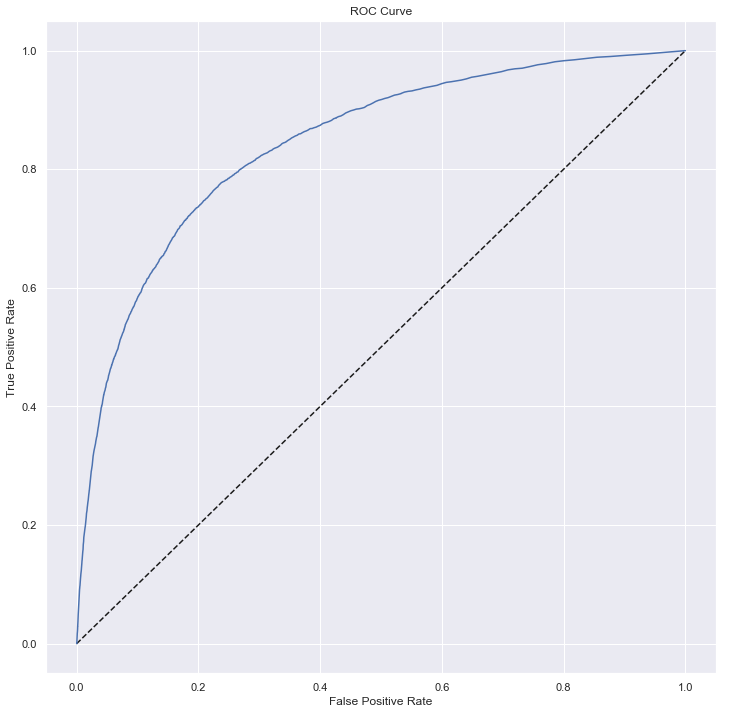

In [27]:
# ROC Curve
y_r_pred_prob = clf.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_r_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_r_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# SVM

In [28]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler


In [30]:

svm_test(X_train, y_train, X_test, y_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C=0.5,score=0.9309089694783944
[[55559   387]
 [ 3751   195]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C=1.0,score=0.9368363053496294
[[55739   207]
 [ 3576   370]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C=1.5,score=0.9364856742135844
[[55768   178]
 [ 3626   320]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C=2.0,score=0.7915915314232285
[[46208  9738]
 [ 2744  1202]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C=4.0,score=0.17391304347826086
[[ 6896 49050]
 [  426  3520]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C=8.0,score=0.9340479529820344
[[55667   279]
 [ 3671   275]]
C=10.0,score=0.9354337808054498
[[55628   318]
 [ 3549   397]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [41]:
linSVC = svm.LinearSVC(random_state=50,  max_iter = 1000, C=4.0) # tol=1e-5,
linSVC.fit(X_train, y_train)

y_r_pred = linSVC.predict(X_test)

#print('Confusion Matrix:')
#print(confusion_matrix(y_test, y_r_pred))
#print()
print_stats(y_test, y_r_pred)

Confusion Matrix:
[[53181  2765]
 [ 3518   428]]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     55946
           1       0.13      0.11      0.12      3946

   micro avg       0.90      0.90      0.90     59892
   macro avg       0.54      0.53      0.53     59892
weighted avg       0.88      0.90      0.89     59892


Accuracy Score: 0.8950945034395245


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Annex - Ignore for now.

In [ ]:
scaler = StandardScaler() # Standarize features
X_std = scaler.fit_transform(X_train)

svc = svm.SVC(class_weight='balanced', C=5.0, random_state=50, probability=True) # kernel='linear', 



In [ ]:
# Train classifier
model = svc.predict(X_std, y_train)



In [ ]:
print(svc.predict_proba(X_test))


In [ ]:
print(svc.predict_log_proba(X_test))

In [ ]:
print_stats(y_test, y_r_pred)